# LBM internals: distributions

 - Inspection of  distributions on the lattice
 - Inspection of symbolic module in sailfish: `sym`, `sym_equilibrium`

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys, os

sys.path.append( os.path.join(os.environ.get("HOME"),"sailfish") ) 

datapath = os.path.join( "/dev/shm/",os.environ.get("USER"),"data")
try:
    os.makedirs(datapath,mode=0755)
except OSError as ex:
    print datapath,"::",ex.strerror

if not os.path.isdir('data') and os.path.islink('data'):
    os.remove("data")
    
if not os.path.islink('data'):
    os.symlink(datapath, "data")

%env BASH_ENV= ~/.bash_profile

/dev/shm/marcin.kostur/data :: File exists
env: BASH_ENV=~/.bash_profile


In [2]:
import sympy
sympy.init_printing(use_latex='mathjax')


In [3]:
%%writefile data/ex1.py
import numpy as np
from sailfish.subdomain import Subdomain2D
from sailfish.node_type import NTFullBBWall, NTEquilibriumVelocity
from sailfish.controller import LBSimulationController
from sailfish.lb_single import LBFluidSim

class MyBlock(Subdomain2D):
    max_v = 0.1

    def boundary_conditions(self, hx, hy):
        wall_map = ( (hx == self.gx-1) | (hx == 0) | (hy == 0) )
        self.set_node( (hy == self.gy-1) & (hx>0) & (hx<self.gx-1) , NTEquilibriumVelocity((self.max_v, 0.0)) )
        self.set_node(wall_map, NTFullBBWall)
        
    def initial_conditions(self, sim, hx, hy):
        sim.rho[:] = 1.0

class MySim(LBFluidSim):
    subdomain = MyBlock

LBSimulationController(MySim).run()

Overwriting data/ex1.py


We run above code with `--debug_dump_dists` which creates files for distributions.

In [4]:
%%bash
export PYTHONPATH=$PWD/sailfish/
python data/ex1.py --max_iters=100 --every=1 --from=99\
 --lat_nx=30 --lat_ny=30 \
 --visc=0.01\
 --output=data/ex1 --output_format=npy --debug_dump_dists --block_size=32

[   720  INFO Master/gpu4.smcebi.us.edu.pl] Machine master starting with PID 97907 at 2017-02-28 10:43:53 UTC
[   720  INFO Master/gpu4.smcebi.us.edu.pl] Simulation started with: data/ex1.py --max_iters=100 --every=1 --from=99 --lat_nx=30 --lat_ny=30 --visc=0.01 --output=data/ex1 --output_format=npy --debug_dump_dists --block_size=32
[   735  INFO Master/gpu4.smcebi.us.edu.pl] Sailfish version: dcc3d33d3c6fe420f78ff1af13471774ef283c74
[   735  INFO Master/gpu4.smcebi.us.edu.pl] Handling subdomains: [0]
[   735  INFO Master/gpu4.smcebi.us.edu.pl] Subdomain -> GPU map: {0: 0}
[   735  INFO Master/gpu4.smcebi.us.edu.pl] Selected backend: cuda
[  1028  INFO Subdomain/0] Initializing subdomain.
[  1030  INFO Subdomain/0] Required memory: 
[  1030  INFO Subdomain/0] . distributions: 0 MiB
[  1031  INFO Subdomain/0] . fields: 0 MiB
[  2266  INFO Subdomain/0] Starting simulation.
[  2289  INFO Subdomain/0] Simulation completed after 100 iterations.


In [5]:
!ls -lrta data/ex1*

-rw-r--r-- 1 marcin.kostur staff   705 Feb 28 11:43 data/ex1.py
-rw-r--r-- 1 marcin.kostur staff   586 Feb 28 11:43 data/ex1.subdomains
-rw-r--r-- 1 marcin.kostur staff 25262 Feb 28 11:43 data/ex1_dists.0.099.npz
-rw-r--r-- 1 marcin.kostur staff  8956 Feb 28 11:43 data/ex1.0.100.npz


In [6]:
data = np.load("data/ex1_dists.0.099.npz")
data.files

['arr_0']

In [7]:
print data['arr_0'].shape

(9, 32, 32)


In [8]:
print data['arr_0'].shape

(9, 32, 32)


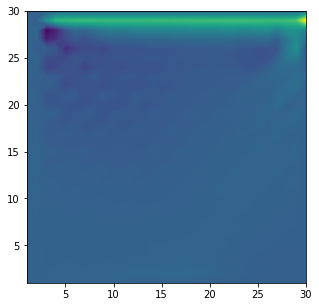

In [9]:
dists = data['arr_0']
ny,nx = 32,32
Y,X = np.mgrid[0:ny,0:nx]
plt.figure(figsize=(5,ny/nx*5))
plt.xlim(1,nx-2)
plt.ylim(1,ny-2)
plt.contourf(X,Y,dists[8,:,:],256)


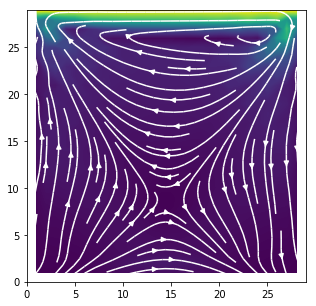

In [10]:
data = np.load("data/ex1.0.100.npz")
vx,vy = data['v']
rho = data['rho']
ny,nx = vx.shape
Y,X = np.mgrid[0:ny,0:nx]
plt.figure(figsize=(5,ny/nx*5))
plt.xlim(0,nx-1)
plt.ylim(0,ny-1)
plt.contourf(X,Y,np.sqrt(vy**2+vx**2),256)
vy[np.isnan(vy)] = 0.0
vx[np.isnan(vx)] = 0.0
plt.streamplot(X,Y,vx,vy,color='white')

### Calculation of  the first two moments of velocity distribution

Let us calculate $v_x$, using values of distributions at given node and time point.

So, we have for node `[27,15]`:

In [11]:
vx.shape,dists.shape

((30, 30), (9, 32, 32))

In [12]:
dists[:,27,15]

array([ 0.44355109,  0.11037402,  0.11154962,  0.11141087,  0.11031891,
        0.02707268,  0.02842675,  0.02713086,  0.02819799], dtype=float32)

#### Density 

Thus the formula for the the first moment  - density reads:

$$\rho = {\sum_i f_i },$$



So let us check, taking into the account that distributions contain ghost nodes:

In [13]:
rho[26,14],np.sum(dists[:,27,15])

(0.99803275, 0.99803281)

#### Velocity

The formula for the velocity reads:

$$\vec u = \frac{\sum_i f_i \vec e_i }{\sum_i f_i },$$

and can be easily written in numpy as. We will use set of velocities $\vec e_i$ for a given model defined in sailfish. 

In [14]:
from sailfish import sym
from sailfish import sym_equilibrium
from sympy import Matrix

In [15]:
print sym.D2Q9.basis

[Matrix([[0, 0]]), Matrix([[1, 0]]), Matrix([[0, 1]]), Matrix([[-1, 0]]), Matrix([[0, -1]]), Matrix([[1, 1]]), Matrix([[-1, 1]]), Matrix([[-1, -1]]), Matrix([[1, -1]])]


thus we have:

In [16]:
sum([map(float,c*fi)[0] for c,fi in zip(sym.D2Q9.basis,dists[:,27,15])])/np.sum(dists[:,27,15])

-0.00132641356906

In [17]:
vx[26,14]

-0.0013264061

### Equilibrium distributions

Type:

    sym_equilibrium.bgk_equilibrium??

to see the soruce code.

Note: in order to caclulate equilibrium we need config object. We can create a minimal class which has required parameters for our purpose now.

In [18]:
class C:
    incompressible = False
    minimize_roundoff = False
config = C()
sym_equilibrium.bgk_equilibrium(sym.D2Q9,config)

⎛⎡       ⎛         2          2⎞                ⎛                             
⎜⎢       ⎜  3⋅g0m1x    3⋅g0m1y ⎟                ⎜                      3⋅g0m1y
⎜⎢4⋅g0m0⋅⎜- ──────── - ────────⎟           g0m0⋅⎜g0m1x⋅(3⋅g0m1x + 3) - ───────
⎜⎢       ⎝     2          2    ⎠   4⋅g0m0       ⎝                         2   
⎜⎢────────────────────────────── + ──────, ───────────────────────────────────
⎝⎣              9                    9                       9                

2⎞              ⎛         2                      ⎞              ⎛             
 ⎟              ⎜  3⋅g0m1x                       ⎟              ⎜             
─⎟         g0m0⋅⎜- ──────── + g0m1y⋅(3⋅g0m1y + 3)⎟         g0m0⋅⎜g0m1x⋅(3⋅g0m1
 ⎠   g0m0       ⎝     2                          ⎠   g0m0       ⎝             
── + ────, ─────────────────────────────────────── + ────, ───────────────────
      9                       9                       9                      9

                2⎞              ⎛         2       

Sailfish has general internal notation for moments - e.g. `g0m1y` means second component of the first moment of first field. It is simply $v_x$. There is a set of convienient aliases which can bring those formulas to nicer form. They are used e.g. in firld naming during I/O. 

Let us try it:

In [19]:
from sailfish.sym import S as SS

def subs(a):
    if hasattr(a,"subs"):
        return a.subs(SS.aliases)
    else:
        return a          
            

In [20]:
SS.aliases

{g0m1z: 'vz',
 g0m1y: 'vy',
 g0m1x: 'vx',
 g1m0: 'phi',
 g2m0: 'theta',
 g0m0: 'rho'}

In [21]:
map(subs,sym_equilibrium.bgk_equilibrium(sym.D2Q9,config)[0])

⎡    ⎛      2       2⎞          ⎛                    2⎞        ⎛      2       
⎢    ⎜  3⋅vx    3⋅vy ⎟          ⎜                3⋅vy ⎟        ⎜  3⋅vx        
⎢4⋅ρ⋅⎜- ───── - ─────⎟        ρ⋅⎜vx⋅(3⋅vx + 3) - ─────⎟      ρ⋅⎜- ───── + vy⋅(
⎢    ⎝    2       2  ⎠   4⋅ρ    ⎝                  2  ⎠   ρ    ⎝    2         
⎢───────────────────── + ───, ───────────────────────── + ─, ─────────────────
⎣          9              9               9               9               9   

         ⎞        ⎛                    2⎞        ⎛      2                ⎞    
         ⎟        ⎜                3⋅vy ⎟        ⎜  3⋅vx                 ⎟    
3⋅vy + 3)⎟      ρ⋅⎜vx⋅(3⋅vx - 3) - ─────⎟      ρ⋅⎜- ───── + vy⋅(3⋅vy - 3)⎟    
         ⎠   ρ    ⎝                  2  ⎠   ρ    ⎝    2                  ⎠   ρ
────────── + ─, ───────────────────────── + ─, ─────────────────────────── + ─
             9              9               9               9                9

                                                  

We can compute values of BGK equilibrium distribution, for example 

$$ f_{eq}(\rho=1,\vec v = (0,0)),$$ we have:

In [22]:
import sympy as S
g0m0,g0m1x,g0m1y = S.symbols('g0m0,g0m1x,g0m1y')

print sym_equilibrium.bgk_equilibrium(sym.D2Q9,config)[0][0].subs([(g0m0,1),(g0m1x,0),(g0m1y,0)]).n()

0.444444444444444


In [23]:
feq = sym_equilibrium.bgk_equilibrium(sym.D2Q9,config)[0]

This equilibrium  is normalized:

In [24]:
print subs(sum(feq).simplify())

rho


In [25]:
subs(sum(feq)) # no simplify ;-)

    ⎛      2       2⎞     ⎛      2                ⎞     ⎛      2              
    ⎜  3⋅vx    3⋅vy ⎟     ⎜  3⋅vx                 ⎟     ⎜  3⋅vx               
4⋅ρ⋅⎜- ───── - ─────⎟   ρ⋅⎜- ───── + vy⋅(3⋅vy - 3)⎟   ρ⋅⎜- ───── + vy⋅(3⋅vy + 
    ⎝    2       2  ⎠     ⎝    2                  ⎠     ⎝    2                
───────────────────── + ─────────────────────────── + ────────────────────────
          9                          9                             9          

  ⎞     ⎛                    2⎞     ⎛                    2⎞                   
  ⎟     ⎜                3⋅vy ⎟     ⎜                3⋅vy ⎟                   
3)⎟   ρ⋅⎜vx⋅(3⋅vx - 3) - ─────⎟   ρ⋅⎜vx⋅(3⋅vx + 3) - ─────⎟                   
  ⎠     ⎝                  2  ⎠     ⎝                  2  ⎠   ρ⋅(vx⋅(3⋅vx - 9⋅
─── + ───────────────────────── + ───────────────────────── + ────────────────
                  9                           9                               

                                                  

In [26]:
feq[1]*sym.D2Q9.basis[1][0]

     ⎛                             2⎞       
     ⎜                      3⋅g0m1y ⎟       
g0m0⋅⎜g0m1x⋅(3⋅g0m1x + 3) - ────────⎟       
     ⎝                         2    ⎠   g0m0
───────────────────────────────────── + ────
                  9                      9  

There is also an indentity:

$$ \sum_{i=1}^Q f_i \vec e_i = \rho \vec v$$

In [27]:


vv = [f*e for f,e in zip(feq,sym.D2Q9.basis)]


Sympy does not like to sum list of matrices (chk - `sum(vv)` would yield an error, but we can do:

In [28]:
suma  = Matrix([[0, 0]])
for f,e in zip(feq,sym.D2Q9.basis):
    suma += f*e
suma.simplify()
subs(suma)

[ρ⋅vx  ρ⋅vy]

Equilibrium distribution is supposed to give also a kinetic energy in isothermal model:

In [29]:
suma  = 0
u = Matrix([[g0m1x, g0m1y]])
for f,e in zip(feq,sym.D2Q9.basis):
    suma += f*(e-u).dot(e-u)
subs(suma.simplify())

2⋅ρ
───
 3 

In [30]:
suma  = 0
u = Matrix([[g0m1x, g0m1y]])
for f,e in zip(feq,sym.D2Q9.basis):
    suma += f*(e).dot(e)
subs(suma.simplify().expand())

    2       2   2⋅ρ
ρ⋅vx  + ρ⋅vy  + ───
                 3 

### Ploting distributions for D2Q9

(-1.2, 1.2)

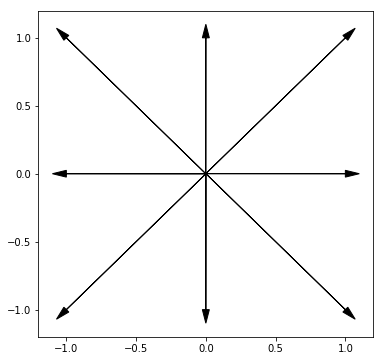

In [31]:
plt.figure(figsize=(6,6))
ax = plt.axes()

for b in sym.D2Q9.basis[1:]:
    ax.arrow(0, 0, *map(float,b), head_width=0.05, head_length=0.1, fc='k', ec='k')

plt.xlim(-1.2,1.2)
plt.ylim(-1.2,1.2)

In [32]:
eq_fncs = sym_equilibrium.bgk_equilibrium(sym.D2Q9,config)[0]

In [33]:
d = [float(ex.subs([(g0m0,1),(g0m1x,.2),(g0m1y,0.2)]) ) for ex in eq_fncs]
d

[0.391111111111, 0.184444444444, 0.184444444444, 0.0511111111111, 0.0511111111
111, 0.0777777777778, 0.0244444444444, 0.0111111111111, 0.0244444444444]

(-0.4, 0.4)

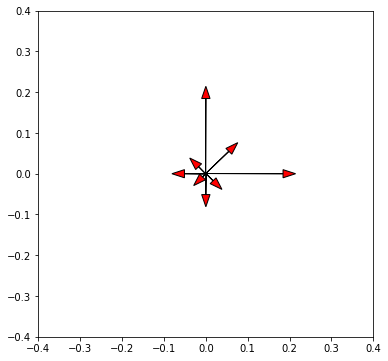

In [34]:
plt.figure(figsize=(6,6))
ax = plt.axes()

for w,b in zip(sym.D2Q9.basis[1:],d[1:]):
    ax.arrow(0, 0, *map(float,b*w.normalized()), head_width=0.02, head_length=0.03, fc='r', ec='k')
a=.4
plt.xlim(-a,a)
plt.ylim(-a,a)

In [35]:
d = [float(ex.subs([(g0m0,1),(g0m1x,vx[27,15]),(g0m1y,vy[27,15])]) ) for ex in eq_fncs]
d

[0.444070526329, 0.11918052771, 0.11143577737, 0.103414044909, 0.110601053513,
 0.0299070712453, 0.0259506448035, 0.025756769581, 0.0296835845393]

#### $f$ & $f_{eq}$

Let us compare $f_{eq}$ with actual - nonequilibrium distribution on single node:

(-0.3, 0.3)

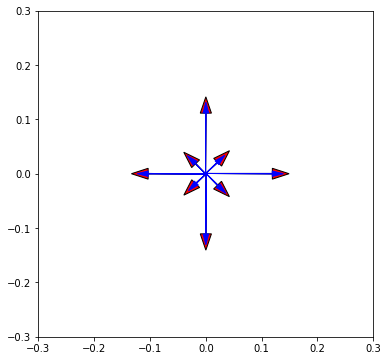

In [36]:
d = [float(ex.subs([(g0m0,1),(g0m1x,vx[27,15]),(g0m1y,vy[27,15])]) ) for ex in eq_fncs]
dnon = dists[:,28,16]
plt.figure(figsize=(6,6))
ax = plt.axes()

for w,b in zip(sym.D2Q9.basis[1:],d[1:]):
    ax.arrow(0, 0, *map(float,b*w.normalized()), head_width=0.02, head_length=0.03, fc='r', ec='k')
for w,b in zip(sym.D2Q9.basis[1:],dnon[1:]):
    ax.arrow(0, 0, *map(float,b*w.normalized()), head_width=0.01, head_length=0.02, fc='b', ec='b')
    
a=.3
plt.xlim(-a,a)
plt.ylim(-a,a)

Pure nonequilibrium part (50x enlarged!)

(-0.3, 0.3)

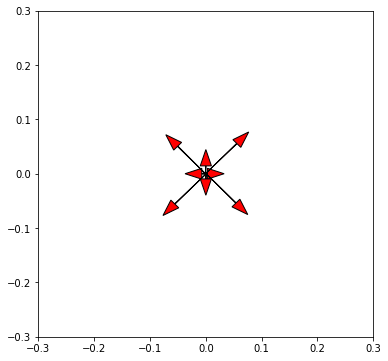

In [37]:


d = [float(ex.subs([(g0m0,1),(g0m1x,vx[27,15]),(g0m1y,vy[27,15])]) ) for ex in eq_fncs]
dnon = dists[:,28,16]
plt.figure(figsize=(6,6))
ax = plt.axes()

for w,b in zip(sym.D2Q9.basis[1:],dnon[1:]-d[1:]):
    ax.arrow(0, 0, *map(float,50*b*w.normalized()), head_width=0.02, head_length=0.03, fc='r', ec='k')
    
a=.3
plt.xlim(-a,a)
plt.ylim(-a,a)

In [38]:
d

[0.444070526329, 0.11918052771, 0.11143577737, 0.103414044909, 0.110601053513,
 0.0299070712453, 0.0259506448035, 0.025756769581, 0.0296835845393]

In [39]:
dnon

array([ 0.44411162,  0.11903486,  0.11172451,  0.10335904,  0.11079217,
        0.02833352,  0.0273797 ,  0.0241851 ,  0.03120823], dtype=float32)

In [40]:
d-dnon

array([ -4.10890907e-05,   1.45671152e-04,  -2.88733419e-04,
         5.50087618e-05,  -1.91113972e-04,   1.57354700e-03,
        -1.42905797e-03,   1.57166901e-03,  -1.52464751e-03])

In [41]:
from ipywidgets.widgets import interact, interactive, fixed
from ipywidgets import widgets

In [42]:
from IPython.display import clear_output, display, HTML


def show_eq(vx,vy):
    
    d = [float(ex.subs([(g0m0,1),(g0m1x,vx),(g0m1y,vy)]) ) for ex in eq_fncs]

    plt.figure(figsize=(6,6))
    ax = plt.axes()

    for w,b in zip(sym.D2Q9.basis[1:],d[1:]):
        ax.arrow(0, 0, *map(float,b*w.normalized()), head_width=0.02, head_length=0.03, fc='r', ec='k')
        if b<0:
            print "Negative distribution:",w
    a=.4
    plt.xlim(-a,a)
    plt.ylim(-a,a)
    
    plt.show()

Negative distribution: Matrix([[-1, 0]])
Negative distribution: Matrix([[0, -1]])


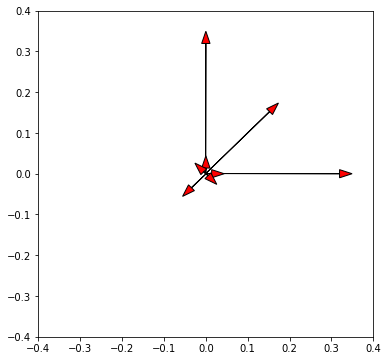

In [43]:
w = interactive(show_eq, vx=(0.,1.0), vy=(0,1.))
display(w)